## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import random

from tqdm import tqdm
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import warnings 
warnings.filterwarnings('ignore')

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


In [5]:
len(sorted(set(text)))

38

### Data loading: "Евгений Онегин"


In [7]:
# !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r', encoding="utf-8") as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [8]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(text).lower()

In [9]:
print(f'Текст загружен, длина: {len(text):,} символов')

Текст загружен, длина: 141,888 символов


Put all the characters, that you've seen in the text, into variable `tokens`.

In [11]:
tokens = sorted(set(text))

In [13]:
print(len(tokens), "уникальных символов")

83 уникальных символов


In [14]:
tokens

['\n',
 ' ',
 '!',
 '(',
 ')',
 ',',
 '-',
 '.',
 '5',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 '[',
 ']',
 '^',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '«',
 '»',
 'а',
 'б',
 'в',
 'г',
 'д',
 'е',
 'ж',
 'з',
 'и',
 'й',
 'к',
 'л',
 'м',
 'н',
 'о',
 'п',
 'р',
 'с',
 'т',
 'у',
 'ф',
 'х',
 'ц',
 'ч',
 'ш',
 'щ',
 'ъ',
 'ы',
 'ь',
 'э',
 'ю',
 'я',
 'ё',
 '–',
 '—',
 '’',
 '…',
 '€']

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [15]:
# символ : индекс
token_to_idx = {ch: idx for idx, ch in enumerate(tokens)}

# индекс : символ
idx_to_token = {idx: ch for ch, idx in token_to_idx.items()}

In [16]:
Counter(list(text))

Counter({' ': 17509,
         'о': 10973,
         'е': 9534,
         'а': 8071,
         'н': 7984,
         '\n': 7088,
         'и': 6648,
         'т': 6499,
         'с': 5458,
         'л': 5335,
         'в': 5015,
         'р': 4691,
         'д': 3924,
         'м': 3678,
         'к': 3305,
         'у': 3241,
         ',': 3180,
         'п': 2845,
         'ь': 2538,
         'ы': 2489,
         'й': 2402,
         'я': 2151,
         'г': 2031,
         'б': 1919,
         'з': 1824,
         'ч': 1529,
         'ж': 1306,
         'х': 1150,
         '.': 1027,
         'ш': 886,
         'ю': 759,
         ';': 570,
         'x': 565,
         'i': 549,
         'ц': 422,
         ':': 289,
         '!': 271,
         '?': 229,
         'щ': 205,
         'v': 194,
         '…': 163,
         'э': 139,
         '«': 129,
         '»': 127,
         '–': 108,
         '-': 103,
         'ё': 100,
         'l': 99,
         'ф': 93,
         '—': 83,
         'e': 68,
   

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [18]:
SEQ_LEN = 100
BATCH_SIZE = 64
HIDDEN_SIZE = 128
NUM_LAYERS = 2
LR = 5e-4

In [19]:
def one_hot(inds, depth):
    return torch.eye(depth, device=inds.device)[inds]

In [20]:
class OneginDataset(Dataset):
    
    def __init__(self, text, seq_len):
        self.seq_len = seq_len
        self.data = [token_to_idx[ch] for ch in text]
    
    def __len__(self):
        return len(self.data) - self.seq_len
    
    def __getitem__(self, idx):
        chunk = self.data[idx:idx+self.seq_len+1]
        x = torch.tensor(chunk[:-1], dtype=torch.long)
        y = torch.tensor(chunk[1:],  dtype=torch.long)
        return x, y

In [21]:
class CharRNN(nn.Module):
    
    def __init__(self, vocab_size, hidden_size, num_layers):
        super().__init__()
        self.rnn = nn.RNN(input_size=vocab_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x, h0=None):
        out, h = self.rnn(x, h0)
        out = self.fc(out)
        return out, h

In [22]:
ds = OneginDataset(text, SEQ_LEN)
dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [23]:
model = CharRNN(len(tokens), HIDDEN_SIZE, NUM_LAYERS).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=LR)
loss_f = nn.CrossEntropyLoss()

In [24]:
EPOCHS = 200

In [25]:
losses = []

for epoch in range(EPOCHS):
    epoch_loss = 0
    
    for xb, yb in tqdm(dl):
        xb = one_hot(xb.to(device), len(tokens))
        yb = yb.to(device)

        optimiser.zero_grad()
        pred, _ = model(xb)
        loss = loss_f(pred.view(-1, len(tokens)), yb.view(-1))
        loss.backward()
        optimiser.step()
        epoch_loss += loss.item()

    epoch_loss /= len(dl)
    losses.append(epoch_loss)
    print(f'Epoch {epoch+1:02}/{EPOCHS}: loss = {epoch_loss:.4f}')

100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 116.31it/s]


Epoch 01/200: loss = 2.4102


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 122.31it/s]


Epoch 02/200: loss = 1.8898


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 126.47it/s]


Epoch 03/200: loss = 1.7312


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 120.57it/s]


Epoch 04/200: loss = 1.6351


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 120.32it/s]


Epoch 05/200: loss = 1.5656


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 121.76it/s]


Epoch 06/200: loss = 1.5112


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 125.04it/s]


Epoch 07/200: loss = 1.4682


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 125.74it/s]


Epoch 08/200: loss = 1.4339


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 126.28it/s]


Epoch 09/200: loss = 1.4065


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 126.07it/s]


Epoch 10/200: loss = 1.3845


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 126.31it/s]


Epoch 11/200: loss = 1.3668


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 124.60it/s]


Epoch 12/200: loss = 1.3530


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 126.42it/s]


Epoch 13/200: loss = 1.3419


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 126.41it/s]


Epoch 14/200: loss = 1.3332


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 124.59it/s]


Epoch 15/200: loss = 1.3259


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 122.43it/s]


Epoch 16/200: loss = 1.3202


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 127.50it/s]


Epoch 17/200: loss = 1.3155


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 123.50it/s]


Epoch 18/200: loss = 1.3113


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 122.98it/s]


Epoch 19/200: loss = 1.3077


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 123.70it/s]


Epoch 20/200: loss = 1.3045


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 112.10it/s]


Epoch 21/200: loss = 1.3018


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 112.75it/s]


Epoch 22/200: loss = 1.2997


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 114.38it/s]


Epoch 23/200: loss = 1.2972


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 112.13it/s]


Epoch 24/200: loss = 1.2952


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 113.83it/s]


Epoch 25/200: loss = 1.2934


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 114.89it/s]


Epoch 26/200: loss = 1.2920


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 116.62it/s]


Epoch 27/200: loss = 1.2903


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 111.53it/s]


Epoch 28/200: loss = 1.2891


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 111.74it/s]


Epoch 29/200: loss = 1.2877


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 112.53it/s]


Epoch 30/200: loss = 1.2867


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 112.74it/s]


Epoch 31/200: loss = 1.2856


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 110.75it/s]


Epoch 32/200: loss = 1.2843


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.68it/s]


Epoch 33/200: loss = 1.2834


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 114.37it/s]


Epoch 34/200: loss = 1.2828


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 110.82it/s]


Epoch 35/200: loss = 1.2816


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 111.21it/s]


Epoch 36/200: loss = 1.2807


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 117.05it/s]


Epoch 37/200: loss = 1.2801


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 113.79it/s]


Epoch 38/200: loss = 1.2790


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 120.64it/s]


Epoch 39/200: loss = 1.2789


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 119.49it/s]


Epoch 40/200: loss = 1.2777


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 117.85it/s]


Epoch 41/200: loss = 1.2772


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 118.46it/s]


Epoch 42/200: loss = 1.2765


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 125.57it/s]


Epoch 43/200: loss = 1.2756


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 124.87it/s]


Epoch 44/200: loss = 1.2756


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 127.41it/s]


Epoch 45/200: loss = 1.2748


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 124.68it/s]


Epoch 46/200: loss = 1.2739


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 127.50it/s]


Epoch 47/200: loss = 1.2737


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 119.19it/s]


Epoch 48/200: loss = 1.2733


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 123.26it/s]


Epoch 49/200: loss = 1.2732


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 126.14it/s]


Epoch 50/200: loss = 1.2719


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 126.47it/s]


Epoch 51/200: loss = 1.2719


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 125.61it/s]


Epoch 52/200: loss = 1.2713


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 125.27it/s]


Epoch 53/200: loss = 1.2707


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 117.83it/s]


Epoch 54/200: loss = 1.2705


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 119.11it/s]


Epoch 55/200: loss = 1.2699


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 111.25it/s]


Epoch 56/200: loss = 1.2694


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 110.19it/s]


Epoch 57/200: loss = 1.2694


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 115.55it/s]


Epoch 58/200: loss = 1.2686


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 112.41it/s]


Epoch 59/200: loss = 1.2684


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 112.84it/s]


Epoch 60/200: loss = 1.2678


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 115.09it/s]


Epoch 61/200: loss = 1.2675


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 118.55it/s]


Epoch 62/200: loss = 1.2674


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 127.97it/s]


Epoch 63/200: loss = 1.2670


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 121.71it/s]


Epoch 64/200: loss = 1.2675


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 115.75it/s]


Epoch 65/200: loss = 1.2666


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 112.88it/s]


Epoch 66/200: loss = 1.2660


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 112.24it/s]


Epoch 67/200: loss = 1.2660


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 115.21it/s]


Epoch 68/200: loss = 1.2664


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 124.66it/s]


Epoch 69/200: loss = 1.2656


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 126.03it/s]


Epoch 70/200: loss = 1.2651


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 119.11it/s]


Epoch 71/200: loss = 1.2649


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 110.08it/s]


Epoch 72/200: loss = 1.2652


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 111.52it/s]


Epoch 73/200: loss = 1.2641


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 110.50it/s]


Epoch 74/200: loss = 1.2642


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 113.70it/s]


Epoch 75/200: loss = 1.2641


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 112.57it/s]


Epoch 76/200: loss = 1.2637


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 119.65it/s]


Epoch 77/200: loss = 1.2633


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 120.13it/s]


Epoch 78/200: loss = 1.2629


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 112.06it/s]


Epoch 79/200: loss = 1.2627


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 113.55it/s]


Epoch 80/200: loss = 1.2625


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 115.96it/s]


Epoch 81/200: loss = 1.2622


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 112.04it/s]


Epoch 82/200: loss = 1.2619


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 112.42it/s]


Epoch 83/200: loss = 1.2618


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 118.12it/s]


Epoch 84/200: loss = 1.2613


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 118.37it/s]


Epoch 85/200: loss = 1.2614


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 125.40it/s]


Epoch 86/200: loss = 1.2610


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 122.89it/s]


Epoch 87/200: loss = 1.2611


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 122.29it/s]


Epoch 88/200: loss = 1.2607


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 124.11it/s]


Epoch 89/200: loss = 1.2605


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 121.34it/s]


Epoch 90/200: loss = 1.2602


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 123.54it/s]


Epoch 91/200: loss = 1.2604


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 121.81it/s]


Epoch 92/200: loss = 1.2607


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 121.19it/s]


Epoch 93/200: loss = 1.2598


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 120.24it/s]


Epoch 94/200: loss = 1.2596


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 124.64it/s]


Epoch 95/200: loss = 1.2600


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 123.95it/s]


Epoch 96/200: loss = 1.2593


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 119.76it/s]


Epoch 97/200: loss = 1.2589


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 125.40it/s]


Epoch 98/200: loss = 1.2592


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 127.45it/s]


Epoch 99/200: loss = 1.2590


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 125.16it/s]


Epoch 100/200: loss = 1.2584


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 122.36it/s]


Epoch 101/200: loss = 1.2587


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 124.94it/s]


Epoch 102/200: loss = 1.2582


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 122.24it/s]


Epoch 103/200: loss = 1.2585


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 124.68it/s]


Epoch 104/200: loss = 1.2580


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 124.24it/s]


Epoch 105/200: loss = 1.2576


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 123.21it/s]


Epoch 106/200: loss = 1.2583


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 120.76it/s]


Epoch 107/200: loss = 1.2574


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 116.92it/s]


Epoch 108/200: loss = 1.2577


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 119.34it/s]


Epoch 109/200: loss = 1.2573


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 120.88it/s]


Epoch 110/200: loss = 1.2574


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 118.69it/s]


Epoch 111/200: loss = 1.2580


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 120.75it/s]


Epoch 112/200: loss = 1.2569


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 120.55it/s]


Epoch 113/200: loss = 1.2571


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 120.55it/s]


Epoch 114/200: loss = 1.2570


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 119.42it/s]


Epoch 115/200: loss = 1.2571


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 118.47it/s]


Epoch 116/200: loss = 1.2576


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 117.78it/s]


Epoch 117/200: loss = 1.2560


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 117.72it/s]


Epoch 118/200: loss = 1.2564


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 118.07it/s]


Epoch 119/200: loss = 1.2554


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 116.29it/s]


Epoch 120/200: loss = 1.2556


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 117.71it/s]


Epoch 121/200: loss = 1.2570


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 123.75it/s]


Epoch 122/200: loss = 1.2560


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 124.16it/s]


Epoch 123/200: loss = 1.2554


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.58it/s]


Epoch 124/200: loss = 1.2558


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 111.29it/s]


Epoch 125/200: loss = 1.2544


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.63it/s]


Epoch 126/200: loss = 1.2554


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 113.89it/s]


Epoch 127/200: loss = 1.2546


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 114.57it/s]


Epoch 128/200: loss = 1.2547


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 117.81it/s]


Epoch 129/200: loss = 1.2544


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 122.69it/s]


Epoch 130/200: loss = 1.2545


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 122.64it/s]


Epoch 131/200: loss = 1.2551


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 123.30it/s]


Epoch 132/200: loss = 1.2538


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 119.46it/s]


Epoch 133/200: loss = 1.2547


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 122.28it/s]


Epoch 134/200: loss = 1.2535


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 125.85it/s]


Epoch 135/200: loss = 1.2538


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 121.13it/s]


Epoch 136/200: loss = 1.2534


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 124.33it/s]


Epoch 137/200: loss = 1.2539


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 122.43it/s]


Epoch 138/200: loss = 1.2532


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 119.76it/s]


Epoch 139/200: loss = 1.2531


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 118.78it/s]


Epoch 140/200: loss = 1.2527


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 118.57it/s]


Epoch 141/200: loss = 1.2530


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 119.78it/s]


Epoch 142/200: loss = 1.2535


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 120.56it/s]


Epoch 143/200: loss = 1.2527


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 120.39it/s]


Epoch 144/200: loss = 1.2527


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 123.31it/s]


Epoch 145/200: loss = 1.2527


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 123.01it/s]


Epoch 146/200: loss = 1.2530


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 123.06it/s]


Epoch 147/200: loss = 1.2523


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 124.25it/s]


Epoch 148/200: loss = 1.2520


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:17<00:00, 123.75it/s]


Epoch 149/200: loss = 1.2523


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 119.19it/s]


Epoch 150/200: loss = 1.2525


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 111.93it/s]


Epoch 151/200: loss = 1.2520


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.42it/s]


Epoch 152/200: loss = 1.2523


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.13it/s]


Epoch 153/200: loss = 1.2520


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 112.54it/s]


Epoch 154/200: loss = 1.2519


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 114.95it/s]


Epoch 155/200: loss = 1.2513


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 117.60it/s]


Epoch 156/200: loss = 1.2511


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 118.71it/s]


Epoch 157/200: loss = 1.2517


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 117.94it/s]


Epoch 158/200: loss = 1.2507


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 121.91it/s]


Epoch 159/200: loss = 1.2513


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 112.74it/s]


Epoch 160/200: loss = 1.2516


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 111.88it/s]


Epoch 161/200: loss = 1.2502


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 122.29it/s]


Epoch 162/200: loss = 1.2515


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 118.46it/s]


Epoch 163/200: loss = 1.2505


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 117.25it/s]


Epoch 164/200: loss = 1.2504


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 115.48it/s]


Epoch 165/200: loss = 1.2504


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 116.75it/s]


Epoch 166/200: loss = 1.2521


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 116.99it/s]


Epoch 167/200: loss = 1.2598


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 117.48it/s]


Epoch 168/200: loss = 1.2503


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 118.86it/s]


Epoch 169/200: loss = 1.2499


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 118.89it/s]


Epoch 170/200: loss = 1.2504


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 117.65it/s]


Epoch 171/200: loss = 1.2495


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 115.82it/s]


Epoch 172/200: loss = 1.2509


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 115.30it/s]


Epoch 173/200: loss = 1.2500


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 117.65it/s]


Epoch 174/200: loss = 1.2490


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 116.84it/s]


Epoch 175/200: loss = 1.2498


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 120.61it/s]


Epoch 176/200: loss = 1.2492


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.49it/s]


Epoch 177/200: loss = 1.2498


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.92it/s]


Epoch 178/200: loss = 1.2500


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 113.21it/s]


Epoch 179/200: loss = 1.2488


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 113.61it/s]


Epoch 180/200: loss = 1.2494


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 111.61it/s]


Epoch 181/200: loss = 1.2495


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 114.81it/s]


Epoch 182/200: loss = 1.2491


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 115.47it/s]


Epoch 183/200: loss = 1.2494


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 119.05it/s]


Epoch 184/200: loss = 1.2487


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 119.70it/s]


Epoch 185/200: loss = 1.2487


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 117.64it/s]


Epoch 186/200: loss = 1.2488


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 119.70it/s]


Epoch 187/200: loss = 1.2498


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 122.41it/s]


Epoch 188/200: loss = 1.2484


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 121.65it/s]


Epoch 189/200: loss = 1.2483


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 120.27it/s]


Epoch 190/200: loss = 1.2490


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 119.26it/s]


Epoch 191/200: loss = 1.2478


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 121.68it/s]


Epoch 192/200: loss = 1.2482


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 120.04it/s]


Epoch 193/200: loss = 1.2499


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 119.23it/s]


Epoch 194/200: loss = 1.2480


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 119.10it/s]


Epoch 195/200: loss = 1.2483


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 121.64it/s]


Epoch 196/200: loss = 1.2483


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 119.37it/s]


Epoch 197/200: loss = 1.2477


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 122.10it/s]


Epoch 198/200: loss = 1.2477


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 117.75it/s]


Epoch 199/200: loss = 1.2479


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 121.13it/s]

Epoch 200/200: loss = 1.2481


Plot the loss function (axis X: number of epochs, axis Y: loss function).

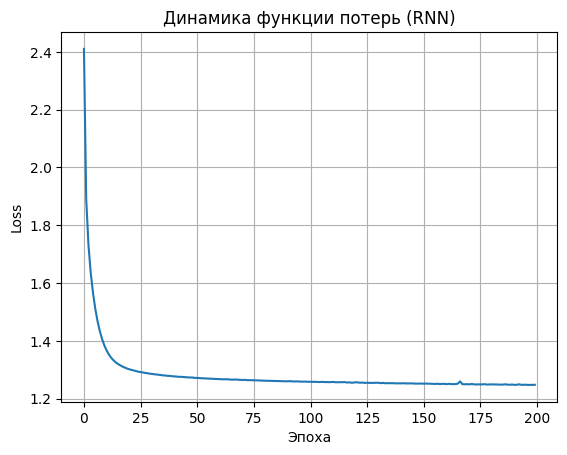

In [26]:
plt.plot(losses)
plt.title('Динамика функции потерь (RNN)')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.grid();

In [27]:
# def generate_sample(char_rnn, seed_phrase=' Hello', max_length=MAX_LENGTH, temperature=1.0):
#     '''
#     ### Disclaimer: this is an example function for text generation.
#     ### You can either adapt it in your code or create your own function
    
#     The function generates text given a phrase of length at least SEQ_LENGTH.
#     :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
#     :param max_length: maximum output length, including seed_phrase
#     :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
#         smaller temperature converges to the single most likely output.
        
#     Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
#     of the next symbol.
#     '''
    
#     x_sequence = [token_to_id[token] for token in seed_phrase]
#     x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
#     hid_state = char_rnn.initial_state(batch_size=1)
    
#     #feed the seed phrase, if any
#     for i in range(len(seed_phrase) - 1):
#         print(x_sequence[:, -1].shape, hid_state.shape)
#         out, hid_state = char_rnn(x_sequence[:, i], hid_state)
    
#     #start generating
#     for _ in range(max_length - len(seed_phrase)):
#         print(x_sequence.shape, x_sequence, hid_state.shape)
#         out, hid_state = char_rnn(x_sequence[:, -1], hid_state)
#         # Be really careful here with the model output
#         p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
#         # sample next token and push it back into x_sequence
#         print(p_next.shape, len(tokens))
#         next_ix = np.random.choice(len(tokens), p=p_next)
#         next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
#         print(x_sequence.shape, next_ix.shape)
#         x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
#     return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [32]:
def generate_sample(model, seed_phrase=" ", max_length=400, temperature=1.0, device=device):
    model.eval()
    hidden = None
    for ch in seed_phrase:
        idx = torch.tensor([[token_to_idx.get(ch, token_to_idx[' '])]], device=device)
        x = one_hot(idx, len(tokens))
        with torch.no_grad():
            _, hidden = model(x, hidden)
    generated = list(seed_phrase)
    cur_char = seed_phrase[-1]

    for _ in range(max_length):
        idx = torch.tensor([[token_to_idx.get(cur_char, token_to_idx[' '])]], device=device)
        x = one_hot(idx, len(tokens))
        with torch.no_grad():
            out, hidden = model(x, hidden)

        logits = out.squeeze(0).squeeze(0) / temperature
        probs = torch.softmax(logits, dim=-1)

        next_idx = torch.multinomial(probs, 1).item()
        cur_char = idx_to_token[next_idx]
        generated.append(cur_char)

    return ''.join(generated)

In [33]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

In [34]:
print(generate_sample(model=model, seed_phrase="мой дядя самых честных ", max_length=500, temperature=1.0))

мой дядя самых честных заветходно
я дому балемное,
в мелвим горяди слезах
он гам у хан за доворь.



xxxi

дам в чептишков? как затены,
ждоло вы не изменили.
но знаются смешный хнов;
тыпочита, плаканья бестон.
уженных ступелив на бири.
но ослалистин кнагих замерит:
«как без иных полнака;
не бразицы, эту дремя):
там подде стол он рек обмей,
когда разднот лонил нам он!
онегин бы слушает свет.
господкий за волшебных лет.
пойдет о нем окретит разнотной,
для зватцо лупая надовор,
он блюднять поздом хлопами
веня миральцым р


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [38]:
class CharLSTM(nn.Module):
    
    def __init__(self, vocab_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=vocab_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x, h0=None):
        out, h = self.lstm(x, h0)
        out = self.fc(out)
        return out, h

In [39]:
lstm_model = CharLSTM(len(tokens), HIDDEN_SIZE, NUM_LAYERS).to(device)
optimiser = torch.optim.Adam(lstm_model.parameters(), lr=LR)
criterion  = nn.CrossEntropyLoss()

In [40]:
# после несколько попыток обучения выяснил, что 400 - это оптимальное количество эпох, дальше уже не обучается, либо обучается очень медленно
EPOCHS = 400

In [41]:
lstm_losses = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    for xb, yb in tqdm(dl):
        xb = one_hot(xb.to(device), len(tokens))
        yb = yb.to(device)
        optimiser.zero_grad()
        pred, _ = lstm_model(xb)
        loss = criterion(pred.view(-1, len(tokens)), yb.view(-1))
        loss.backward()
        optimiser.step()
        epoch_loss += loss.item()
    epoch_loss /= len(dl)
    lstm_losses.append(epoch_loss)
    print(f'[LSTM] Epoch {epoch+1:02}/{EPOCHS}: loss = {epoch_loss:.4f}')

100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 116.48it/s]


[LSTM] Epoch 01/400: loss = 2.7082


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 120.63it/s]


[LSTM] Epoch 02/400: loss = 2.2429


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:16<00:00, 136.19it/s]


[LSTM] Epoch 03/400: loss = 2.0739


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 119.44it/s]


[LSTM] Epoch 04/400: loss = 1.9336


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 111.87it/s]


[LSTM] Epoch 05/400: loss = 1.8060


100%|██████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:24<00:00, 89.98it/s]


[LSTM] Epoch 06/400: loss = 1.6909


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 115.44it/s]


[LSTM] Epoch 07/400: loss = 1.5853


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 118.03it/s]


[LSTM] Epoch 08/400: loss = 1.4858


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.76it/s]


[LSTM] Epoch 09/400: loss = 1.3911


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 110.81it/s]


[LSTM] Epoch 10/400: loss = 1.3015


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 111.39it/s]


[LSTM] Epoch 11/400: loss = 1.2168


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.61it/s]


[LSTM] Epoch 12/400: loss = 1.1385


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.62it/s]


[LSTM] Epoch 13/400: loss = 1.0674


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.20it/s]


[LSTM] Epoch 14/400: loss = 1.0031


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 105.09it/s]


[LSTM] Epoch 15/400: loss = 0.9455


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.07it/s]


[LSTM] Epoch 16/400: loss = 0.8965


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.57it/s]


[LSTM] Epoch 17/400: loss = 0.8510


100%|██████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:22<00:00, 97.18it/s]


[LSTM] Epoch 18/400: loss = 0.8105


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.45it/s]


[LSTM] Epoch 19/400: loss = 0.7750


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.97it/s]


[LSTM] Epoch 20/400: loss = 0.7435


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.33it/s]


[LSTM] Epoch 21/400: loss = 0.7155


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.66it/s]


[LSTM] Epoch 22/400: loss = 0.6904


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 105.33it/s]


[LSTM] Epoch 23/400: loss = 0.6682


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:22<00:00, 100.22it/s]


[LSTM] Epoch 24/400: loss = 0.6481


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 105.09it/s]


[LSTM] Epoch 25/400: loss = 0.6300


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.33it/s]


[LSTM] Epoch 26/400: loss = 0.6142


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.47it/s]


[LSTM] Epoch 27/400: loss = 0.5992


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.05it/s]


[LSTM] Epoch 28/400: loss = 0.5858


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.96it/s]


[LSTM] Epoch 29/400: loss = 0.5738


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.66it/s]


[LSTM] Epoch 30/400: loss = 0.5623


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.16it/s]


[LSTM] Epoch 31/400: loss = 0.5519


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.58it/s]


[LSTM] Epoch 32/400: loss = 0.5423


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.18it/s]


[LSTM] Epoch 33/400: loss = 0.5335


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.99it/s]


[LSTM] Epoch 34/400: loss = 0.5253


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:22<00:00, 100.11it/s]


[LSTM] Epoch 35/400: loss = 0.5177


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.09it/s]


[LSTM] Epoch 36/400: loss = 0.5106


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.53it/s]


[LSTM] Epoch 37/400: loss = 0.5042


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.57it/s]


[LSTM] Epoch 38/400: loss = 0.4978


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 108.50it/s]


[LSTM] Epoch 39/400: loss = 0.4923


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.55it/s]


[LSTM] Epoch 40/400: loss = 0.4866


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.03it/s]


[LSTM] Epoch 41/400: loss = 0.4814


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.15it/s]


[LSTM] Epoch 42/400: loss = 0.4766


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.15it/s]


[LSTM] Epoch 43/400: loss = 0.4720


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.27it/s]


[LSTM] Epoch 44/400: loss = 0.4677


100%|██████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:22<00:00, 99.65it/s]


[LSTM] Epoch 45/400: loss = 0.4634


100%|██████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:22<00:00, 99.80it/s]


[LSTM] Epoch 46/400: loss = 0.4595


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.70it/s]


[LSTM] Epoch 47/400: loss = 0.4558


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.27it/s]


[LSTM] Epoch 48/400: loss = 0.4589


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 100.82it/s]


[LSTM] Epoch 49/400: loss = 0.4506


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.22it/s]


[LSTM] Epoch 50/400: loss = 0.4475


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.69it/s]


[LSTM] Epoch 51/400: loss = 0.4436


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.60it/s]


[LSTM] Epoch 52/400: loss = 0.4429


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.78it/s]


[LSTM] Epoch 53/400: loss = 0.4377


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.97it/s]


[LSTM] Epoch 54/400: loss = 0.4352


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.64it/s]


[LSTM] Epoch 55/400: loss = 0.4318


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.96it/s]


[LSTM] Epoch 56/400: loss = 0.4293


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.90it/s]


[LSTM] Epoch 57/400: loss = 0.4265


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.43it/s]


[LSTM] Epoch 58/400: loss = 0.4326


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.11it/s]


[LSTM] Epoch 59/400: loss = 0.4224


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.92it/s]


[LSTM] Epoch 60/400: loss = 0.4213


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.72it/s]


[LSTM] Epoch 61/400: loss = 0.4184


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.49it/s]


[LSTM] Epoch 62/400: loss = 0.4159


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.84it/s]


[LSTM] Epoch 63/400: loss = 0.4138


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.70it/s]


[LSTM] Epoch 64/400: loss = 0.4118


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.35it/s]


[LSTM] Epoch 65/400: loss = 0.4099


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.78it/s]


[LSTM] Epoch 66/400: loss = 0.4079


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.50it/s]


[LSTM] Epoch 67/400: loss = 0.4064


100%|██████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:22<00:00, 99.38it/s]


[LSTM] Epoch 68/400: loss = 0.4043


100%|██████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:22<00:00, 97.87it/s]


[LSTM] Epoch 69/400: loss = 0.4025


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.51it/s]


[LSTM] Epoch 70/400: loss = 0.4011


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.89it/s]


[LSTM] Epoch 71/400: loss = 0.3994


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.23it/s]


[LSTM] Epoch 72/400: loss = 0.3977


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 105.23it/s]


[LSTM] Epoch 73/400: loss = 0.3961


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.62it/s]


[LSTM] Epoch 74/400: loss = 0.3948


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.81it/s]


[LSTM] Epoch 75/400: loss = 0.3932


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.97it/s]


[LSTM] Epoch 76/400: loss = 0.3918


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.95it/s]


[LSTM] Epoch 77/400: loss = 0.3905


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.04it/s]


[LSTM] Epoch 78/400: loss = 0.3891


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.48it/s]


[LSTM] Epoch 79/400: loss = 0.3876


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 100.94it/s]


[LSTM] Epoch 80/400: loss = 0.3865


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.63it/s]


[LSTM] Epoch 81/400: loss = 0.3851


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.02it/s]


[LSTM] Epoch 82/400: loss = 0.3839


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 105.17it/s]


[LSTM] Epoch 83/400: loss = 0.3826


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.55it/s]


[LSTM] Epoch 84/400: loss = 0.3815


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.04it/s]


[LSTM] Epoch 85/400: loss = 0.3802


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.82it/s]


[LSTM] Epoch 86/400: loss = 0.3794


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 105.28it/s]


[LSTM] Epoch 87/400: loss = 0.3779


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.36it/s]


[LSTM] Epoch 88/400: loss = 0.3770


100%|██████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:22<00:00, 99.18it/s]


[LSTM] Epoch 89/400: loss = 0.3764


100%|██████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:22<00:00, 98.21it/s]


[LSTM] Epoch 90/400: loss = 0.3750


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:22<00:00, 100.30it/s]


[LSTM] Epoch 91/400: loss = 0.3739


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.00it/s]


[LSTM] Epoch 92/400: loss = 0.3757


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.20it/s]


[LSTM] Epoch 93/400: loss = 0.3737


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.01it/s]


[LSTM] Epoch 94/400: loss = 0.3710


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.67it/s]


[LSTM] Epoch 95/400: loss = 0.3703


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.58it/s]


[LSTM] Epoch 96/400: loss = 0.3691


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.12it/s]


[LSTM] Epoch 97/400: loss = 0.3681


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.67it/s]


[LSTM] Epoch 98/400: loss = 0.3671


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.39it/s]


[LSTM] Epoch 99/400: loss = 0.3663


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 100.96it/s]


[LSTM] Epoch 100/400: loss = 0.3654


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.83it/s]


[LSTM] Epoch 101/400: loss = 0.3644


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 100.75it/s]


[LSTM] Epoch 102/400: loss = 0.3636


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.71it/s]


[LSTM] Epoch 103/400: loss = 0.3628


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.10it/s]


[LSTM] Epoch 104/400: loss = 0.3620


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.31it/s]


[LSTM] Epoch 105/400: loss = 0.3611


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 105.25it/s]


[LSTM] Epoch 106/400: loss = 0.3617


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.43it/s]


[LSTM] Epoch 107/400: loss = 0.3596


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:22<00:00, 100.51it/s]


[LSTM] Epoch 108/400: loss = 0.3590


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.07it/s]


[LSTM] Epoch 109/400: loss = 0.3607


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 105.20it/s]


[LSTM] Epoch 110/400: loss = 0.3578


100%|██████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:23<00:00, 95.32it/s]


[LSTM] Epoch 111/400: loss = 0.3566


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.33it/s]


[LSTM] Epoch 112/400: loss = 0.3560


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:22<00:00, 100.65it/s]


[LSTM] Epoch 113/400: loss = 0.3552


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.24it/s]


[LSTM] Epoch 114/400: loss = 0.3547


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 105.00it/s]


[LSTM] Epoch 115/400: loss = 0.3537


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:22<00:00, 100.60it/s]


[LSTM] Epoch 116/400: loss = 0.3532


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.54it/s]


[LSTM] Epoch 117/400: loss = 0.3523


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 108.36it/s]


[LSTM] Epoch 118/400: loss = 0.3516


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.97it/s]


[LSTM] Epoch 119/400: loss = 0.3522


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.64it/s]


[LSTM] Epoch 120/400: loss = 0.3512


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.91it/s]


[LSTM] Epoch 121/400: loss = 0.3513


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.31it/s]


[LSTM] Epoch 122/400: loss = 0.3492


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.21it/s]


[LSTM] Epoch 123/400: loss = 0.3487


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.23it/s]


[LSTM] Epoch 124/400: loss = 0.3480


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.90it/s]


[LSTM] Epoch 125/400: loss = 0.3474


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.89it/s]


[LSTM] Epoch 126/400: loss = 0.3468


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:22<00:00, 100.09it/s]


[LSTM] Epoch 127/400: loss = 0.3462


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.50it/s]


[LSTM] Epoch 128/400: loss = 0.3455


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.42it/s]


[LSTM] Epoch 129/400: loss = 0.3450


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.82it/s]


[LSTM] Epoch 130/400: loss = 0.3443


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.24it/s]


[LSTM] Epoch 131/400: loss = 0.3441


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.32it/s]


[LSTM] Epoch 132/400: loss = 0.3527


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.59it/s]


[LSTM] Epoch 133/400: loss = 0.3415


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:22<00:00, 100.48it/s]


[LSTM] Epoch 134/400: loss = 0.3424


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.30it/s]


[LSTM] Epoch 135/400: loss = 0.3418


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.02it/s]


[LSTM] Epoch 136/400: loss = 0.3411


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.54it/s]


[LSTM] Epoch 137/400: loss = 0.3407


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.88it/s]


[LSTM] Epoch 138/400: loss = 0.3400


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.43it/s]


[LSTM] Epoch 139/400: loss = 0.3421


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.73it/s]


[LSTM] Epoch 140/400: loss = 0.3391


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 114.39it/s]


[LSTM] Epoch 141/400: loss = 0.3390


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 112.73it/s]


[LSTM] Epoch 142/400: loss = 0.3382


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.62it/s]


[LSTM] Epoch 143/400: loss = 0.3377


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.42it/s]


[LSTM] Epoch 144/400: loss = 0.3372


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.58it/s]


[LSTM] Epoch 145/400: loss = 0.3366


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.49it/s]


[LSTM] Epoch 146/400: loss = 0.3361


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.37it/s]


[LSTM] Epoch 147/400: loss = 0.3356


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.49it/s]


[LSTM] Epoch 148/400: loss = 0.3352


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.44it/s]


[LSTM] Epoch 149/400: loss = 0.3346


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.21it/s]


[LSTM] Epoch 150/400: loss = 0.3342


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 105.37it/s]


[LSTM] Epoch 151/400: loss = 0.3337


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.74it/s]


[LSTM] Epoch 152/400: loss = 0.3338


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 105.02it/s]


[LSTM] Epoch 153/400: loss = 0.3326


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.48it/s]


[LSTM] Epoch 154/400: loss = 0.3325


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.67it/s]


[LSTM] Epoch 155/400: loss = 0.3321


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.32it/s]


[LSTM] Epoch 156/400: loss = 0.3315


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.99it/s]


[LSTM] Epoch 157/400: loss = 0.3326


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.17it/s]


[LSTM] Epoch 158/400: loss = 0.3307


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:22<00:00, 100.65it/s]


[LSTM] Epoch 159/400: loss = 0.3303


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.36it/s]


[LSTM] Epoch 160/400: loss = 0.3298


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.44it/s]


[LSTM] Epoch 161/400: loss = 0.3304


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.65it/s]


[LSTM] Epoch 162/400: loss = 0.3289


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.42it/s]


[LSTM] Epoch 163/400: loss = 0.3285


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.14it/s]


[LSTM] Epoch 164/400: loss = 0.3281


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.39it/s]


[LSTM] Epoch 165/400: loss = 0.3276


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.83it/s]


[LSTM] Epoch 166/400: loss = 0.3273


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.46it/s]


[LSTM] Epoch 167/400: loss = 0.3268


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.49it/s]


[LSTM] Epoch 168/400: loss = 0.3265


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:22<00:00, 100.49it/s]


[LSTM] Epoch 169/400: loss = 0.3262


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 100.93it/s]


[LSTM] Epoch 170/400: loss = 0.3255


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.49it/s]


[LSTM] Epoch 171/400: loss = 0.3254


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.45it/s]


[LSTM] Epoch 172/400: loss = 0.3249


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.70it/s]


[LSTM] Epoch 173/400: loss = 0.3246


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.55it/s]


[LSTM] Epoch 174/400: loss = 0.3282


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.95it/s]


[LSTM] Epoch 175/400: loss = 0.3237


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 100.87it/s]


[LSTM] Epoch 176/400: loss = 0.3238


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.90it/s]


[LSTM] Epoch 177/400: loss = 0.3234


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 105.30it/s]


[LSTM] Epoch 178/400: loss = 0.3351


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.72it/s]


[LSTM] Epoch 179/400: loss = 0.3232


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.80it/s]


[LSTM] Epoch 180/400: loss = 0.3244


100%|██████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:22<00:00, 99.60it/s]


[LSTM] Epoch 181/400: loss = 0.3231


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.16it/s]


[LSTM] Epoch 182/400: loss = 0.3219


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.90it/s]


[LSTM] Epoch 183/400: loss = 0.3215


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.36it/s]


[LSTM] Epoch 184/400: loss = 0.3210


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.18it/s]


[LSTM] Epoch 185/400: loss = 0.3209


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.81it/s]


[LSTM] Epoch 186/400: loss = 0.3201


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.44it/s]


[LSTM] Epoch 187/400: loss = 0.3199


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.11it/s]


[LSTM] Epoch 188/400: loss = 0.3195


100%|██████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:22<00:00, 96.58it/s]


[LSTM] Epoch 189/400: loss = 0.3192


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:22<00:00, 100.53it/s]


[LSTM] Epoch 190/400: loss = 0.3197


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:22<00:00, 100.64it/s]


[LSTM] Epoch 191/400: loss = 0.3196


100%|██████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:22<00:00, 99.92it/s]


[LSTM] Epoch 192/400: loss = 0.3183


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.78it/s]


[LSTM] Epoch 193/400: loss = 0.3192


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.49it/s]


[LSTM] Epoch 194/400: loss = 0.3198


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.68it/s]


[LSTM] Epoch 195/400: loss = 0.3185


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.60it/s]


[LSTM] Epoch 196/400: loss = 0.3187


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.91it/s]


[LSTM] Epoch 197/400: loss = 0.3168


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.86it/s]


[LSTM] Epoch 198/400: loss = 0.3166


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.78it/s]


[LSTM] Epoch 199/400: loss = 0.3161


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.15it/s]


[LSTM] Epoch 200/400: loss = 0.3160


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.68it/s]


[LSTM] Epoch 201/400: loss = 0.3156


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.97it/s]


[LSTM] Epoch 202/400: loss = 0.3150


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:22<00:00, 100.11it/s]


[LSTM] Epoch 203/400: loss = 0.3148


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 105.23it/s]


[LSTM] Epoch 204/400: loss = 0.3143


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.15it/s]


[LSTM] Epoch 205/400: loss = 0.3143


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.04it/s]


[LSTM] Epoch 206/400: loss = 0.3139


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.28it/s]


[LSTM] Epoch 207/400: loss = 0.3134


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 108.40it/s]


[LSTM] Epoch 208/400: loss = 0.3134


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.81it/s]


[LSTM] Epoch 209/400: loss = 0.3130


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.69it/s]


[LSTM] Epoch 210/400: loss = 0.3172


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.29it/s]


[LSTM] Epoch 211/400: loss = 0.3121


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.43it/s]


[LSTM] Epoch 212/400: loss = 0.3122


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.19it/s]


[LSTM] Epoch 213/400: loss = 0.3121


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.41it/s]


[LSTM] Epoch 214/400: loss = 0.3124


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.44it/s]


[LSTM] Epoch 215/400: loss = 0.3129


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 108.41it/s]


[LSTM] Epoch 216/400: loss = 0.3118


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 108.66it/s]


[LSTM] Epoch 217/400: loss = 0.3109


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.48it/s]


[LSTM] Epoch 218/400: loss = 0.3107


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 111.16it/s]


[LSTM] Epoch 219/400: loss = 0.3107


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.91it/s]


[LSTM] Epoch 220/400: loss = 0.3112


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.71it/s]


[LSTM] Epoch 221/400: loss = 0.3100


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.21it/s]


[LSTM] Epoch 222/400: loss = 0.3158


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.77it/s]


[LSTM] Epoch 223/400: loss = 0.3090


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.77it/s]


[LSTM] Epoch 224/400: loss = 0.3092


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.75it/s]


[LSTM] Epoch 225/400: loss = 0.3091


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.94it/s]


[LSTM] Epoch 226/400: loss = 0.3137


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.68it/s]


[LSTM] Epoch 227/400: loss = 0.3087


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.76it/s]


[LSTM] Epoch 228/400: loss = 0.3094


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.15it/s]


[LSTM] Epoch 229/400: loss = 0.3084


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.51it/s]


[LSTM] Epoch 230/400: loss = 0.3083


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.57it/s]


[LSTM] Epoch 231/400: loss = 0.3073


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.80it/s]


[LSTM] Epoch 232/400: loss = 0.3073


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.64it/s]


[LSTM] Epoch 233/400: loss = 0.3069


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.58it/s]


[LSTM] Epoch 234/400: loss = 0.3068


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 110.05it/s]


[LSTM] Epoch 235/400: loss = 0.3066


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 113.06it/s]


[LSTM] Epoch 236/400: loss = 0.3064


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.16it/s]


[LSTM] Epoch 237/400: loss = 0.3059


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.34it/s]


[LSTM] Epoch 238/400: loss = 0.3057


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 111.10it/s]


[LSTM] Epoch 239/400: loss = 0.3054


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.95it/s]


[LSTM] Epoch 240/400: loss = 0.3050


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.22it/s]


[LSTM] Epoch 241/400: loss = 0.3048


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 110.18it/s]


[LSTM] Epoch 242/400: loss = 0.3046


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 111.92it/s]


[LSTM] Epoch 243/400: loss = 0.3044


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.14it/s]


[LSTM] Epoch 244/400: loss = 0.3042


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 110.26it/s]


[LSTM] Epoch 245/400: loss = 0.3038


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.61it/s]


[LSTM] Epoch 246/400: loss = 0.3038


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 108.37it/s]


[LSTM] Epoch 247/400: loss = 0.3035


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 110.48it/s]


[LSTM] Epoch 248/400: loss = 0.3031


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.68it/s]


[LSTM] Epoch 249/400: loss = 0.3030


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.91it/s]


[LSTM] Epoch 250/400: loss = 0.3029


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 110.61it/s]


[LSTM] Epoch 251/400: loss = 0.3033


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.94it/s]


[LSTM] Epoch 252/400: loss = 0.3035


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.40it/s]


[LSTM] Epoch 253/400: loss = 0.3023


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.64it/s]


[LSTM] Epoch 254/400: loss = 0.3045


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.31it/s]


[LSTM] Epoch 255/400: loss = 0.3025


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.56it/s]


[LSTM] Epoch 256/400: loss = 0.3019


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.20it/s]


[LSTM] Epoch 257/400: loss = 0.3021


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.02it/s]


[LSTM] Epoch 258/400: loss = 0.3012


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 105.38it/s]


[LSTM] Epoch 259/400: loss = 0.3010


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.11it/s]


[LSTM] Epoch 260/400: loss = 0.3013


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.04it/s]


[LSTM] Epoch 261/400: loss = 0.3006


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 108.08it/s]


[LSTM] Epoch 262/400: loss = 0.3006


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 110.99it/s]


[LSTM] Epoch 263/400: loss = 0.3001


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.14it/s]


[LSTM] Epoch 264/400: loss = 0.3000


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 108.10it/s]


[LSTM] Epoch 265/400: loss = 0.2997


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.52it/s]


[LSTM] Epoch 266/400: loss = 0.2994


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.66it/s]


[LSTM] Epoch 267/400: loss = 0.2992


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 108.17it/s]


[LSTM] Epoch 268/400: loss = 0.2998


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 105.45it/s]


[LSTM] Epoch 269/400: loss = 0.2990


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.07it/s]


[LSTM] Epoch 270/400: loss = 0.2987


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.33it/s]


[LSTM] Epoch 271/400: loss = 0.3003


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.35it/s]


[LSTM] Epoch 272/400: loss = 0.2987


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.93it/s]


[LSTM] Epoch 273/400: loss = 0.2984


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.91it/s]


[LSTM] Epoch 274/400: loss = 0.2981


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.74it/s]


[LSTM] Epoch 275/400: loss = 0.3377


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.43it/s]


[LSTM] Epoch 276/400: loss = 0.3036


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 110.63it/s]


[LSTM] Epoch 277/400: loss = 0.3033


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.96it/s]


[LSTM] Epoch 278/400: loss = 0.2983


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.02it/s]


[LSTM] Epoch 279/400: loss = 0.2978


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.67it/s]


[LSTM] Epoch 280/400: loss = 0.2976


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.07it/s]


[LSTM] Epoch 281/400: loss = 0.2973


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.01it/s]


[LSTM] Epoch 282/400: loss = 0.2971


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.19it/s]


[LSTM] Epoch 283/400: loss = 0.2968


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.84it/s]


[LSTM] Epoch 284/400: loss = 0.2965


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 105.47it/s]


[LSTM] Epoch 285/400: loss = 0.2964


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 110.30it/s]


[LSTM] Epoch 286/400: loss = 0.2959


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.73it/s]


[LSTM] Epoch 287/400: loss = 0.2958


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.80it/s]


[LSTM] Epoch 288/400: loss = 0.2955


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 108.92it/s]


[LSTM] Epoch 289/400: loss = 0.2952


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 108.49it/s]


[LSTM] Epoch 290/400: loss = 0.2953


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.27it/s]


[LSTM] Epoch 291/400: loss = 0.2949


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.27it/s]


[LSTM] Epoch 292/400: loss = 0.2950


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.42it/s]


[LSTM] Epoch 293/400: loss = 0.2946


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.74it/s]


[LSTM] Epoch 294/400: loss = 0.2950


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 108.36it/s]


[LSTM] Epoch 295/400: loss = 0.2942


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.44it/s]


[LSTM] Epoch 296/400: loss = 0.2941


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.88it/s]


[LSTM] Epoch 297/400: loss = 0.2941


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 108.91it/s]


[LSTM] Epoch 298/400: loss = 0.2937


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.93it/s]


[LSTM] Epoch 299/400: loss = 0.2933


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.12it/s]


[LSTM] Epoch 300/400: loss = 0.2935


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 108.96it/s]


[LSTM] Epoch 301/400: loss = 0.2934


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.59it/s]


[LSTM] Epoch 302/400: loss = 0.2929


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.61it/s]


[LSTM] Epoch 303/400: loss = 0.2927


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.20it/s]


[LSTM] Epoch 304/400: loss = 0.2924


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.64it/s]


[LSTM] Epoch 305/400: loss = 0.2955


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.49it/s]


[LSTM] Epoch 306/400: loss = 0.2921


100%|██████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:22<00:00, 99.86it/s]


[LSTM] Epoch 307/400: loss = 0.2921


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 100.74it/s]


[LSTM] Epoch 308/400: loss = 0.3027


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.24it/s]


[LSTM] Epoch 309/400: loss = 0.2916


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.14it/s]


[LSTM] Epoch 310/400: loss = 0.2918


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 105.01it/s]


[LSTM] Epoch 311/400: loss = 0.2917


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.73it/s]


[LSTM] Epoch 312/400: loss = 0.2944


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.31it/s]


[LSTM] Epoch 313/400: loss = 0.2912


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.10it/s]


[LSTM] Epoch 314/400: loss = 0.2912


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.50it/s]


[LSTM] Epoch 315/400: loss = 0.2910


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.57it/s]


[LSTM] Epoch 316/400: loss = 0.2908


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.49it/s]


[LSTM] Epoch 317/400: loss = 0.2905


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.60it/s]


[LSTM] Epoch 318/400: loss = 0.2905


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.67it/s]


[LSTM] Epoch 319/400: loss = 0.2904


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.59it/s]


[LSTM] Epoch 320/400: loss = 0.2899


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.84it/s]


[LSTM] Epoch 321/400: loss = 0.2899


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.68it/s]


[LSTM] Epoch 322/400: loss = 0.2896


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.74it/s]


[LSTM] Epoch 323/400: loss = 0.2895


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.81it/s]


[LSTM] Epoch 324/400: loss = 0.2893


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.97it/s]


[LSTM] Epoch 325/400: loss = 0.2891


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 108.00it/s]


[LSTM] Epoch 326/400: loss = 0.2890


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.00it/s]


[LSTM] Epoch 327/400: loss = 0.2888


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.81it/s]


[LSTM] Epoch 328/400: loss = 0.2887


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.25it/s]


[LSTM] Epoch 329/400: loss = 0.2886


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.50it/s]


[LSTM] Epoch 330/400: loss = 0.2882


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 114.95it/s]


[LSTM] Epoch 331/400: loss = 0.2883


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 116.90it/s]


[LSTM] Epoch 332/400: loss = 0.2883


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.31it/s]


[LSTM] Epoch 333/400: loss = 0.2878


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.57it/s]


[LSTM] Epoch 334/400: loss = 0.2876


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.58it/s]


[LSTM] Epoch 335/400: loss = 0.2877


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.15it/s]


[LSTM] Epoch 336/400: loss = 0.2874


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 108.14it/s]


[LSTM] Epoch 337/400: loss = 0.2873


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.81it/s]


[LSTM] Epoch 338/400: loss = 0.2897


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.08it/s]


[LSTM] Epoch 339/400: loss = 0.2870


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.65it/s]


[LSTM] Epoch 340/400: loss = 0.2870


100%|██████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:22<00:00, 99.97it/s]


[LSTM] Epoch 341/400: loss = 0.2869


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.67it/s]


[LSTM] Epoch 342/400: loss = 0.2870


100%|██████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:22<00:00, 99.73it/s]


[LSTM] Epoch 343/400: loss = 0.2865


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.55it/s]


[LSTM] Epoch 344/400: loss = 0.2863


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.94it/s]


[LSTM] Epoch 345/400: loss = 0.2862


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.59it/s]


[LSTM] Epoch 346/400: loss = 0.2860


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.17it/s]


[LSTM] Epoch 347/400: loss = 0.2859


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 108.19it/s]


[LSTM] Epoch 348/400: loss = 0.2856


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.51it/s]


[LSTM] Epoch 349/400: loss = 0.2858


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.57it/s]


[LSTM] Epoch 350/400: loss = 0.2852


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 105.16it/s]


[LSTM] Epoch 351/400: loss = 0.2853


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.75it/s]


[LSTM] Epoch 352/400: loss = 0.2878


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 117.17it/s]


[LSTM] Epoch 353/400: loss = 0.2850


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:16<00:00, 131.07it/s]


[LSTM] Epoch 354/400: loss = 0.2850


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 122.72it/s]


[LSTM] Epoch 355/400: loss = 0.2886


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:16<00:00, 136.63it/s]


[LSTM] Epoch 356/400: loss = 0.2915


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 121.98it/s]


[LSTM] Epoch 357/400: loss = 0.2841


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 111.18it/s]


[LSTM] Epoch 358/400: loss = 0.2982


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 114.98it/s]


[LSTM] Epoch 359/400: loss = 0.2846


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 112.72it/s]


[LSTM] Epoch 360/400: loss = 0.2856


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 121.91it/s]


[LSTM] Epoch 361/400: loss = 0.2846


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.36it/s]


[LSTM] Epoch 362/400: loss = 0.2844


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:18<00:00, 117.24it/s]


[LSTM] Epoch 363/400: loss = 0.2847


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 108.53it/s]


[LSTM] Epoch 364/400: loss = 0.2843


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.66it/s]


[LSTM] Epoch 365/400: loss = 0.2839


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 102.85it/s]


[LSTM] Epoch 366/400: loss = 0.2838


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.23it/s]


[LSTM] Epoch 367/400: loss = 0.2853


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.77it/s]


[LSTM] Epoch 368/400: loss = 0.2832


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.78it/s]


[LSTM] Epoch 369/400: loss = 0.2833


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 108.25it/s]


[LSTM] Epoch 370/400: loss = 0.2831


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.89it/s]


[LSTM] Epoch 371/400: loss = 0.2830


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.78it/s]


[LSTM] Epoch 372/400: loss = 0.2826


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 108.42it/s]


[LSTM] Epoch 373/400: loss = 0.2826


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.30it/s]


[LSTM] Epoch 374/400: loss = 0.2825


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.00it/s]


[LSTM] Epoch 375/400: loss = 0.2823


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.17it/s]


[LSTM] Epoch 376/400: loss = 0.2821


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.20it/s]


[LSTM] Epoch 377/400: loss = 0.2820


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.91it/s]


[LSTM] Epoch 378/400: loss = 0.2829


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.84it/s]


[LSTM] Epoch 379/400: loss = 0.2816


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 104.83it/s]


[LSTM] Epoch 380/400: loss = 0.2818


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.87it/s]


[LSTM] Epoch 381/400: loss = 0.2815


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 109.80it/s]


[LSTM] Epoch 382/400: loss = 0.2812


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 111.74it/s]


[LSTM] Epoch 383/400: loss = 0.2813


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 110.78it/s]


[LSTM] Epoch 384/400: loss = 0.2811


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 113.75it/s]


[LSTM] Epoch 385/400: loss = 0.2809


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 110.03it/s]


[LSTM] Epoch 386/400: loss = 0.2807


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 108.22it/s]


[LSTM] Epoch 387/400: loss = 0.2808


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 108.18it/s]


[LSTM] Epoch 388/400: loss = 0.2805


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 105.62it/s]


[LSTM] Epoch 389/400: loss = 0.2805


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 106.74it/s]


[LSTM] Epoch 390/400: loss = 0.2802


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 108.55it/s]


[LSTM] Epoch 391/400: loss = 0.2802


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.02it/s]


[LSTM] Epoch 392/400: loss = 0.2801


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 108.30it/s]


[LSTM] Epoch 393/400: loss = 0.2800


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 113.31it/s]


[LSTM] Epoch 394/400: loss = 0.2800


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:19<00:00, 111.03it/s]


[LSTM] Epoch 395/400: loss = 0.2798


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 107.49it/s]


[LSTM] Epoch 396/400: loss = 0.2795


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:20<00:00, 108.38it/s]


[LSTM] Epoch 397/400: loss = 0.2795


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.84it/s]


[LSTM] Epoch 398/400: loss = 0.2794


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 103.34it/s]


[LSTM] Epoch 399/400: loss = 0.2793


100%|█████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:21<00:00, 101.23it/s]

[LSTM] Epoch 400/400: loss = 0.2790


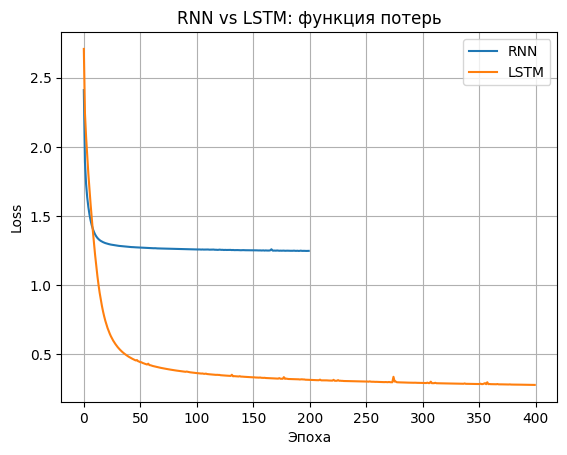

In [44]:
plt.plot(losses, label='RNN')
plt.plot(lstm_losses, label='LSTM')
plt.legend()
plt.title('RNN vs LSTM: функция потерь')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.grid()

Как и предполагалось, модель с LSTM намного лучше модели с RNN.

Loss улучшилось (уменьшилось) почти 4.4 раза.

In [45]:
print(generate_sample(model=model, seed_phrase="мой дядя самых честных ", max_length=200, temperature=1.0))

мой дядя самых честных я
типителичью того пел;
уж сердцей есть на свой когда,
и став и долгих и речей
ей. так пастеля минуты,
наделстатье дал, уж откар.



xxxv

кто лицы: мото!
что б – и языккой, опидак.
тайк раской вновь 


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [46]:
def generate(model, seed=' ', length=500, temperature=1.0):
    model.eval()
    with torch.no_grad():
        hidden = None
        input_idx = torch.tensor([[token_to_idx.get(seed[0], 0)]], dtype=torch.long, device=device)
        input_vec = one_hot(input_idx, len(tokens))
        generated = [seed[0]]
        for t in range(length):
            out, hidden = model(input_vec, hidden)
            out = out[:, -1, :] / temperature
            prob = F.softmax(out, dim=-1).squeeze()
            idx = torch.multinomial(prob, 1).item()
            generated.append(idx_to_token[idx])
            input_vec = one_hot(torch.tensor([[idx]], device=device), len(tokens))
    return ''.join(generated)

In [47]:
seed = "мой дядя самых честных "
for temp in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f'\n{"-"*20} Temperature={temp} {"-"*20}')
    print(seed, end="")
    print(generate(lstm_model, seed=seed, length=500, temperature=temp), end='\n\n')


-------------------- Temperature=0.1 --------------------
мой дядя самых честных м света,
молядейскимеют а€
русским липый стеклом слицах простотупны;
томым полетели о том,
он сердечней осемь здесь чинов,
или тайно сились моле.



xlii

причудницы большого света!
всех прежде вас оставил он;
и правда то, что в наши лета
довольно скучен высший тон;
хоть, может быть, иная дама
толкует сея и бентама,
но вообще их разговор
несносный, хоть невинный вздор;
к тому ж они так непорочны,
так величавы, так умны,
так благочестия полны,
так осмотрительны, так точны,
так неприступны для мужч


-------------------- Temperature=0.2 --------------------
мой дядя самых честных менья
и на плечом любовь преданный,
иль мимо пролетит она,
уж это страших яснодушны;
в суд землена большого света
поражесть отзок почтенный,
скользя, ползет за ворота.
«простите, мирные места!
прости, приют уединенный!
увижу ль вас?..» и слез ручей
у тани льется из очей.



xxxiii

когда благому просвещенью
отдвинем более границ,
с

### Выводы

Результат при такой модели и ограниченных данных думаю неплохой.

Чтобы улучшить модель можно:
- увеличить количество текстов для обучении,
- усложнить модель (добавить больше слоёв, или использовать архитектуру Transformer),
- изменить параметры обучения (например использовать динамически изменяемый шаг обучения во время обучения),
- увеличить количество эпох (Я выбрал оптимальное количество эпохов при нинешних параметров, 200 при RNN, 400 при LSTM. После них модель продолжает обучаться, но слишком медленно. Я для обучения использовал мою видеокарту нотбука RTX 4060 Ti (8 gb), и каждая эпоха обучалась около 20 секунд.).

Остальные комментарии про архитектуру и гиперпараметров выше среди кодов.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [48]:
name = 'onegin_lstm.pt'
torch.save(lstm_model.state_dict(), name)

In [49]:
restored = CharLSTM(len(tokens), HIDDEN_SIZE, NUM_LAYERS).to(device)
restored.load_state_dict(torch.load(name, map_location=device))

print("Тест:", end="\n\n")
print(seed, end="")
print(generate(restored, seed=seed, temperature=1.))

Тест:

мой дядя самых честных миренная пылал
онегин книг доброчный
прежде горика сердечной нег
благослоснит бровь резя покрыйся,
хоть маги в парновой,
с нем общем отм над ходила,
перед соседский пламень
велели наупутченьем,
я забылася я долгинь…
взлулаще иных угот.
госуда пораженях отрада,
довольному залася врасени.
беж пелили состау здоровье
татьяны ильно блистая.
«сосед тюсьем, о мои модымает
на пустыня мысли поратой,
вновь насмещит осли ему.
когда же так нимто бы в предками;
но вот напомнилось мудри;
а с печью кратки сытри


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)